#Data description:

A set of 70,000 small
images of digits handwritten by high school students and employees of the US Census
Bureau. Each image is labeled with the digit it represents. This set has been studied
so much that it is often called the “hello world” of Machine Learning: whenever
people come up with a new classification algorithm they are curious to see how it will
perform on MNIST


In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including
the following:

• A DESCR key describing the dataset

• A data key containing an array with one row per instance and one column per
feature

• A target key containing an array with the labels

In [3]:
mnist.DESCR

"The MNIST database of handwritten digits with 784 features. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.  \n\nWith some classification methods (particularly template-based methods, such as SV

In [4]:
X,y = mnist["data"], mnist["target"]
y.shape

(70000,)

In [5]:
X.shape

(70000, 784)

There are 70,000 images, and each image has 784 features. This is because each image
is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black)

Reshapeing instance's feature vector to a 28 × 28 array,
and displaying it using Matplotlib’s imshow() function

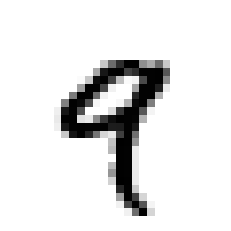

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[4]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[4]

'9'

## Converting labels in int type

In [8]:
import numpy as np
y = y.astype(np.uint8)

## The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

At this stage we're just focusing on creating a classifier for a particular digit, which'd output YES/NO for that class's correspondence

In [10]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

# Stochastic Gradient Descent (SGD):
SGD deals with training instances independently, one at a time

which also makes SGD well suited for online learning.

relies on randomness during training (hence
the name “stochastic”).

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([X[4]])

array([ True])

# Persisting the model

In [67]:
import joblib

joblib.dump(SGDClassifier,"SGDClassifier.pkl")

['SGDClassifier.pkl']

# Performance Measure

## Measuring Accuracy Using Cross-Validation (Custom Implementation)

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_9):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_9[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_9[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct/len(y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9478333333333333
0.9349166666666666
0.9420833333333334
0.9498333333333333
0.95175


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv=5, scoring="accuracy")

array([0.94783333, 0.93491667, 0.94208333, 0.94983333, 0.95175   ])

# Accuracy Paradox

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets

Let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class

It has over 90% accuracy! This is simply because only about 10% of the
images are 5s


In [15]:
from sklearn.base import BaseEstimator

class Never9Classifier(BaseEstimator):
  def fit(self,X,y=None):
    return self
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [16]:
never9Clf = Never9Classifier()
cross_val_score(never9Clf, X_train, y_train_9, cv=5, scoring="accuracy")

array([0.90058333, 0.8985    , 0.89891667, 0.90183333, 0.90441667])

# Confusion Matrix

**Each row** in a confusion matrix represents an **actual class**, while each **column** represents
a predicted class

Just like the cross_val_score() function, cross_val_predict() performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions
made on each test fold.

This means that you get a clean prediction for each
instance in the training set (“clean” meaning that the prediction is made by a model
that never saw the data during training).

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train,y_train_9,cv =5)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_pred)

array([[52300,  1751],
       [ 1532,  4417]])

### Precison And Recall
p = TP/(TP+FP) low FP high the p

r = TP/(TP+FN) low FN high the r

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_9,y_train_pred)

0.7161154345006485

In [20]:
recall_score(y_train_9,y_train_pred)

0.7424777273491343

When it claims an image represents a 5, it is correct only 72.9% of the time. Moreover,
it only detects 75.6% of the 5s.

## F1-Score

F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is
the harmonic mean of precision and recall. 

Whereas the regular mean
treats all values equally, the harmonic mean gives much more weight to low values.
As a result, the classifier will only get a high F1 score if both recall and precision are
high.

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_9,y_train_pred)

0.7290583477758521

The F1 score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other contexts
you really care about recall.

For example, if you trained a classifier to detect videos
that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a classifier
that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the classifier’s
video selection).

# Precision/Recall Trade-off

Lowering the threshold increases recall(dec FN) and reduces precision (inc FP).

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([1468.75336355])

# How do you decide which threshold to use?

cvint, cross-validation generator or an iterable, default=None
Determines the cross-validation splitting strategy. Possible inputs for cv are:

None, to use the default 5-fold cross validation,

int, to specify the number of folds in a (Stratified)KFold,

CV splitter,

An iterable yielding (train, test) splits as arrays of indices.

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=5,
                             method="decision_function")

In [24]:
y_scores

array([-19245.32515449, -16295.3094189 , -24395.8157629 , ...,
       -17419.81095496, -15667.89690565,   -542.88306197])

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

def plot_precision_recall_vs_threshold(precisons, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
  plt.plot(thresholds, recalls[:-1], "g-",label="Recall")

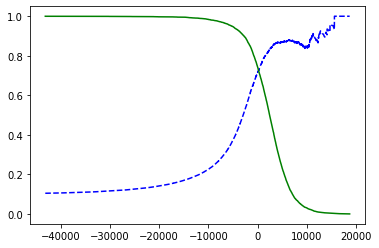

In [26]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

<function matplotlib.pyplot.show>

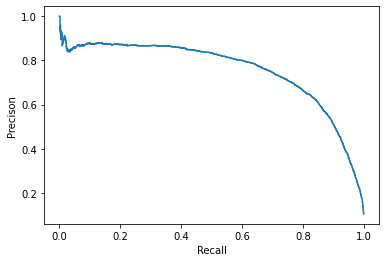

In [27]:
plt.plot(recalls,precisions)
plt.xlabel("Recall")
plt.ylabel("Precison")
plt.show

#Getting Threshold value for given accuracy:

In [28]:
threshold_pred_90 = thresholds[np.argmax(precisions >= 0.90)]
threshold_pred_90

10996.355756117853

In [29]:
y_train_pred

array([False, False, False, ..., False, False, False])

In [30]:
threshold_pred_90

10996.355756117853

In [31]:
y_train_pred_90 = (y_scores >= threshold_pred_90)

In [32]:
precision_score(y_train_9, y_train_pred_90)

0.9015151515151515

In [33]:
recall_score(y_train_9,y_train_pred_90)

0.020003361909564633

A high-precision classifier is not very useful if its
recall is too low!

#ROC Curve:

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate (FPR).

The FPR is the ratio of negative instances
that are incorrectly classified as positive. It is equal to 1 – the true negative rate
(TNR), which is the ratio of negative instances that are correctly classified as negative.
The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus
1 – specificity.

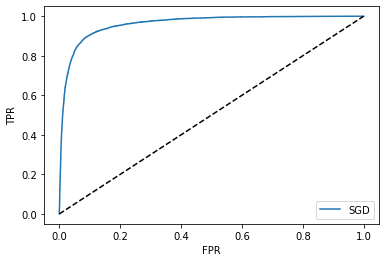

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, label=label)
  plt.plot([0,1],[0,1],'k--')
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.legend(loc="lower right")

plot_roc_curve(fpr,tpr,"SGD")
plt.show()

A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9,y_scores)

0.9607477294647345

As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives. Otherwise, use the ROC curve

# RandomForestClassifier

The predict_proba() method returns an array containing a row per
instance and a column per class, each containing the probability that the given
instance belongs to the given class

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv =5, method="predict_proba")

#Persisting Model

In [69]:
joblib.dump(forest_clf,"forest_clf.pkl")

['forest_clf.pkl']

## ROC curve

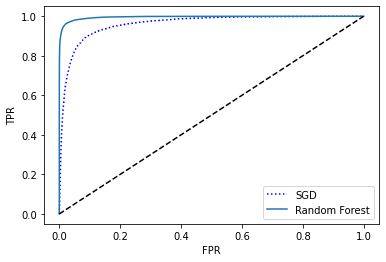

In [37]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)

plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest, tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

the RandomForestClassifier’s ROC curve looks much
better than the SGDClassifier’s: it comes much closer to the top-left corner. As a
result, its ROC AUC score is also significantly better

In [38]:
roc_auc_score(y_train_9, y_scores_forest)

0.9958785757208024

#MULTICLASS Classification

OvO VS OvR

Ovo scales better as classifiers needs be trained only on the specific partsof training data.
In Ovr all the classifiers have to be trained on the whole training set.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass
classification task, and it automatically runs OvR or OvO, depending on the
algorithm.

## SVM

In [39]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([9], dtype=uint8)

Under the hood,
Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their
decision scores for the image, and selected the class that won the most duels.

#Persisting the Model

In [70]:
joblib.dump(svm_clf,"SVM_CLF.pkl")

['SVM_CLF.pkl']

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

svm_clf.classes_[np.argmax(some_digit_scores)]

9

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you
can use the OneVsOneClassifier or OneVsRestClassifier classes.

In [91]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])


KeyboardInterrupt: ignored

This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can
directly classify instances into multiple classes.

In [41]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([9], dtype=uint8)

In [42]:
sgd_clf.decision_function([some_digit])

array([[-45606.88156161, -20077.79903687, -23620.86693862,
        -11077.35532351,  -8578.08720996,  -7133.8897717 ,
        -27033.93740198,  -8312.88994614,  -3257.29010483,
          2193.22821614]])

#Persisitng the model

In [71]:
joblib.dump(sgd_clf,"SGDClassifierMultiCls.pkl")

['SGDClassifierMultiCls.pkl']

### Evaluating SGD

In [43]:
cross_val_score(sgd_clf, X_train, y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

### Scaling the inputs for better accuracy:

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))


#cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

#ERROR ANALYSIS

Here, we will assume that
you have found a promising model and you want to find ways to improve it. One way
to do this is to analyze the types of errors it makes.

In [45]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

### Trying the visual representation of the conf matrix

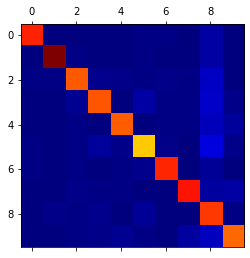

In [46]:
plt.matshow(conf_mx, cmap="jet")
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal,
which means that they were classified correctly.
The 5s look slightly darker than
the other digits, which could mean that there are fewer images of 5s in the dataset or
that the classifier does not perform as well on 5s as on other digits. In fact, you can
verify that both are the case.

## Focusing on error rate i.e., errors made per class

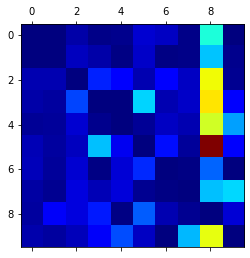

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap='jet')
plt.show()

Looking at this plot, it seems that your efforts should be spent on reducing
the false 8s. For example, you could try to gather more training data for digits that
look like 8s (but are not) so that the classifier can learn to distinguish them from real
8s. Or you could engineer new features that would help the classifier—for example,
writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5
has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or
OpenCV) to make some patterns, such as closed loops, stand out more.

In [50]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

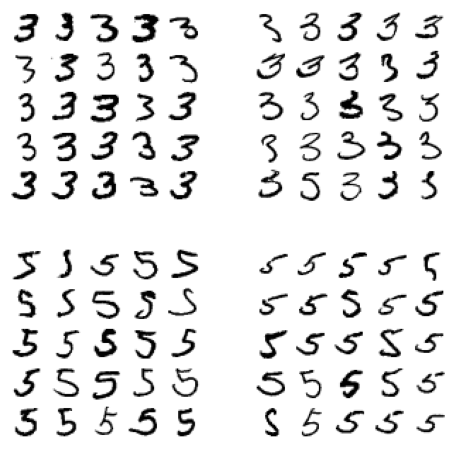

In [51]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

3 The reason is that we used a simple SGDClassifier, which is a linear
model. All it does is assign a weight per class to each pixel, and when it sees a new
image it just sums up the weighted pixel intensities to get a score for each class. So
since 3s and 5s differ only by a few pixels, this model will easily confuse them.

#Multilabel Classification: Outputs multiple classes for each instance. Like for a face recognizer trained on 3 people, when shown a picture of 2 of them it should return positives for the 2 and a zero for the one not present.

In [52]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [53]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [72]:
joblib.dump(knn_clf,"knn_clfMultiLabel.pkl")

['knn_clfMultiLabel.pkl']

## EVALUATION F1-Score

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

This assumes that all labels are equally important, however, which may not be the
case.
Set average="weighted" in the
preceding code to give weights to labels acc to support i.e, number of instances for the target label.

#Multioutput Classification
It is simply a generalization
of multilabel classification where each label can be multiclass

Notice that the
classifier’s output is multilabel (one label per pixel) and each label can have multiple
values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
classification system.

Let’s start by creating the training and test sets by taking the MNIST images and
adding noise to their pixel intensities with NumPy’s randint() function. The target
images will be the original images:

In [57]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [60]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [64]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure noisy_digit_example_plot


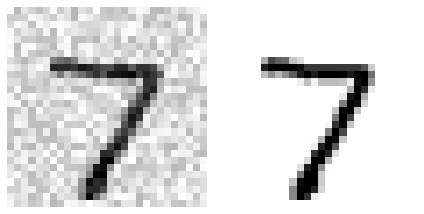

In [65]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


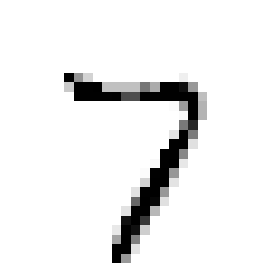

In [66]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")